# Import Libraries

In [1]:
!git clone https://github.com/rushi-the-neural-arch/EVA8-Assignments.git

Cloning into 'EVA8-Assignments'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), 106.01 KiB | 3.31 MiB/s, done.


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0,'/content/EVA8-Assignments/Session_5')

In [4]:
import model

## Data Transformations


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility

if cuda:
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
from model import Net_BN, Net_GN, Net_LN
net_gn = Net_GN().to(device)
net_ln = Net_LN().to(device)
net_bn = Net_BN().to(device)

In [10]:
print(summary(net_gn, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
         GroupNorm-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [11]:
print(summary(net_ln, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
         GroupNorm-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [12]:
print(summary(net_bn, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Model Training

## Group Norm

In [21]:
train_accuracy_logs = {}
test_accuracy_logs = {}
train_loss_logs = {}
test_loss_logs = {}

In [14]:
from torch.optim.lr_scheduler import StepLR

gn_model =  Net_GN().to(device)

optimizer = optim.SGD(gn_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(gn_model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(gn_model, device, test_loader)

EPOCH: 0


Loss=0.052737604826688766 Batch_id=468 Accuracy=84.13: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]



Test set: Average loss: 0.0915, Accuracy: 9759/10000 (97.59%)

EPOCH: 1


Loss=0.09193342924118042 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]



Test set: Average loss: 0.0496, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


Loss=0.12319662421941757 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]



Test set: Average loss: 0.0558, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.0290903989225626 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]



Test set: Average loss: 0.0338, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.028563519939780235 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]



Test set: Average loss: 0.0317, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.0411045216023922 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]



Test set: Average loss: 0.0353, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.05952531471848488 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]



Test set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.03079184703528881 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]



Test set: Average loss: 0.0243, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.03188299760222435 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]



Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.016451938077807426 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]



Test set: Average loss: 0.0221, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.03154786303639412 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:19<00:00, 24.12it/s]



Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.015627028420567513 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]



Test set: Average loss: 0.0233, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.005892567802220583 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]



Test set: Average loss: 0.0227, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.027322860434651375 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]



Test set: Average loss: 0.0223, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.03466137871146202 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0223, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.012761805206537247 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]



Test set: Average loss: 0.0222, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.017390072345733643 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]



Test set: Average loss: 0.0223, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.00511925620958209 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]



Test set: Average loss: 0.0226, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.012627811171114445 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0225, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.012122045271098614 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]



Test set: Average loss: 0.0224, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

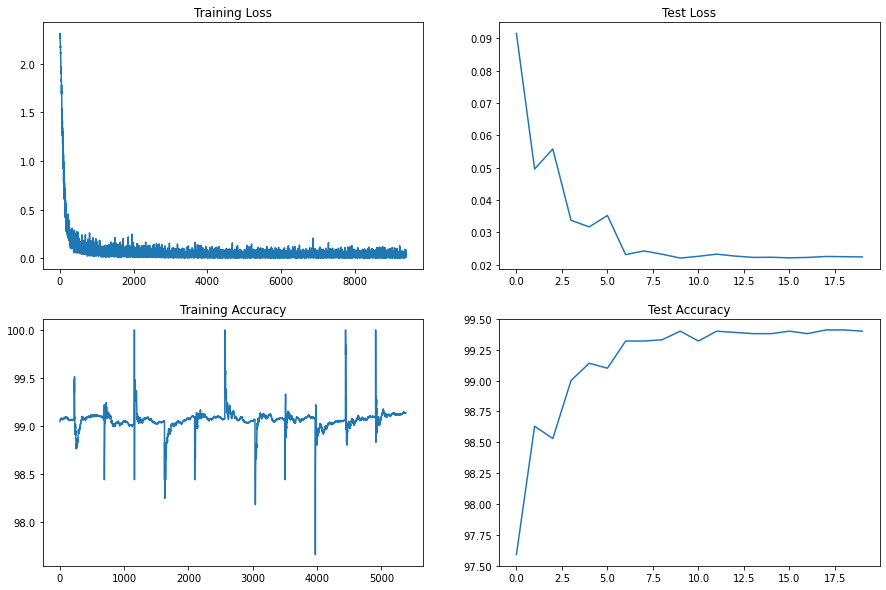

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
train_accuracy_logs['gn'] = train_acc
test_accuracy_logs['gn'] = test_acc
train_loss_logs['gn'] = train_losses
test_loss_logs['gn'] = test_losses

## Layer Norm

In [16]:
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []


ln_model =  Net_LN().to(device)
optimizer = optim.SGD(ln_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(ln_model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(ln_model, device, test_loader)

EPOCH: 0


Loss=2.309943199157715 Batch_id=468 Accuracy=10.77: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]



Test set: Average loss: 2.3012, Accuracy: 1135/10000 (11.35%)

EPOCH: 1


Loss=2.302279233932495 Batch_id=468 Accuracy=11.07: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]



Test set: Average loss: 2.3011, Accuracy: 1135/10000 (11.35%)

EPOCH: 2


Loss=2.296978235244751 Batch_id=468 Accuracy=11.17: 100%|██████████| 469/469 [00:19<00:00, 24.06it/s]



Test set: Average loss: 2.3011, Accuracy: 1135/10000 (11.35%)

EPOCH: 3


Loss=2.300304651260376 Batch_id=468 Accuracy=11.19: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]



Test set: Average loss: 2.3011, Accuracy: 1135/10000 (11.35%)

EPOCH: 4


Loss=2.2969553470611572 Batch_id=468 Accuracy=11.17: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 5


Loss=2.3029091358184814 Batch_id=468 Accuracy=11.13: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 6


Loss=2.303067445755005 Batch_id=468 Accuracy=11.13: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 7


Loss=2.2974021434783936 Batch_id=468 Accuracy=11.21: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 8


Loss=2.3033242225646973 Batch_id=468 Accuracy=11.14: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 9


Loss=2.297590970993042 Batch_id=468 Accuracy=11.16: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 10


Loss=2.297029733657837 Batch_id=468 Accuracy=11.22: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 11


Loss=2.2902767658233643 Batch_id=468 Accuracy=11.21: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 12


Loss=2.2893383502960205 Batch_id=468 Accuracy=11.25: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 13


Loss=2.2944624423980713 Batch_id=468 Accuracy=11.22: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 14


Loss=2.3024911880493164 Batch_id=468 Accuracy=11.21: 100%|██████████| 469/469 [00:19<00:00, 23.85it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 15


Loss=2.2964541912078857 Batch_id=468 Accuracy=11.24: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 16


Loss=2.300119400024414 Batch_id=468 Accuracy=11.18: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 17


Loss=2.296259880065918 Batch_id=468 Accuracy=11.16: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 18


Loss=2.295466661453247 Batch_id=468 Accuracy=11.15: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 19


Loss=2.3053667545318604 Batch_id=468 Accuracy=11.18: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)



Text(0.5, 1.0, 'Test Accuracy')

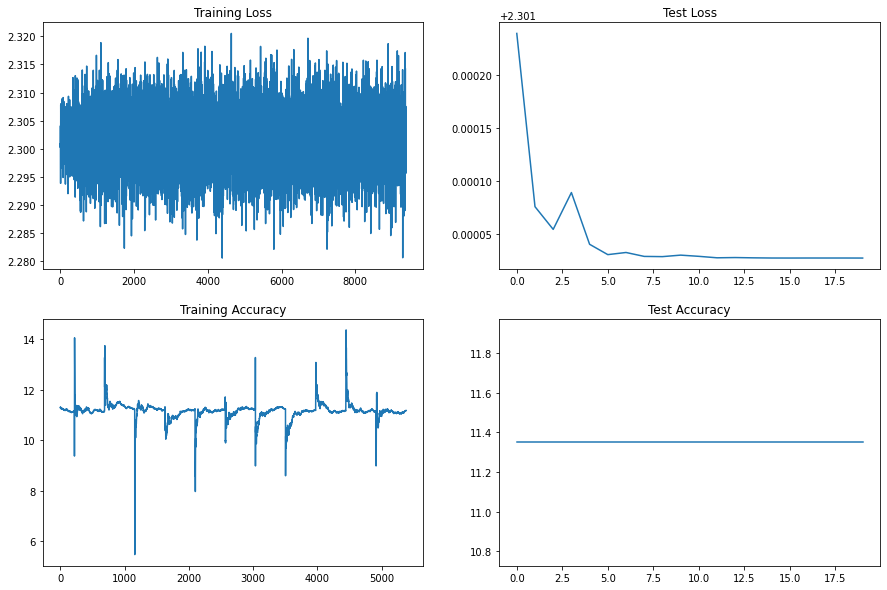

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [22]:
train_accuracy_logs['ln'] = train_acc
test_accuracy_logs['ln'] = test_acc
train_loss_logs['ln'] = train_losses
test_loss_logs['ln'] = test_losses

## Batch Norm with L1 Regularization

In [24]:
def l1_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_lambda = 0.001
    l1_norm = sum(p.sum()
                  for p in model.parameters())
 
    loss = loss + l1_lambda * l1_norm
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [25]:
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []


bn_model =  Net_BN().to(device)
optimizer = optim.SGD(bn_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    l1_train(bn_model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(bn_model, device, test_loader)

EPOCH: 0


Loss=-0.23181116580963135 Batch_id=468 Accuracy=89.59: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]



Test set: Average loss: 0.2439, Accuracy: 9331/10000 (93.31%)

EPOCH: 1


Loss=-0.5760018825531006 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]



Test set: Average loss: 0.1387, Accuracy: 9645/10000 (96.45%)

EPOCH: 2


Loss=-0.9813970923423767 Batch_id=468 Accuracy=96.99: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]



Test set: Average loss: 0.1778, Accuracy: 9589/10000 (95.89%)

EPOCH: 3


Loss=-1.5811069011688232 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]



Test set: Average loss: 0.2953, Accuracy: 9317/10000 (93.17%)

EPOCH: 4


Loss=-2.0336639881134033 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]



Test set: Average loss: 0.3690, Accuracy: 8920/10000 (89.20%)

EPOCH: 5


Loss=-2.4966087341308594 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]



Test set: Average loss: 0.2992, Accuracy: 9485/10000 (94.85%)

EPOCH: 6


Loss=-2.5945520401000977 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]



Test set: Average loss: 0.3000, Accuracy: 9411/10000 (94.11%)

EPOCH: 7


Loss=-2.5710842609405518 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]



Test set: Average loss: 0.3909, Accuracy: 9374/10000 (93.74%)

EPOCH: 8


Loss=-2.6343281269073486 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]



Test set: Average loss: 0.4022, Accuracy: 8854/10000 (88.54%)

EPOCH: 9


Loss=-2.807936191558838 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.4580, Accuracy: 8682/10000 (86.82%)

EPOCH: 10


Loss=-2.7791402339935303 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]



Test set: Average loss: 0.5005, Accuracy: 9066/10000 (90.66%)

EPOCH: 11


Loss=-2.844630479812622 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.5181, Accuracy: 8464/10000 (84.64%)

EPOCH: 12


Loss=-2.90140438079834 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.5508, Accuracy: 8262/10000 (82.62%)

EPOCH: 13


Loss=-2.9200551509857178 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]



Test set: Average loss: 0.5657, Accuracy: 8222/10000 (82.22%)

EPOCH: 14


Loss=-2.8946611881256104 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:19<00:00, 24.51it/s]



Test set: Average loss: 0.5806, Accuracy: 8177/10000 (81.77%)

EPOCH: 15


Loss=-2.740065097808838 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:23<00:00, 19.62it/s]



Test set: Average loss: 0.6069, Accuracy: 8077/10000 (80.77%)

EPOCH: 16


Loss=-2.875035047531128 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s]



Test set: Average loss: 0.5714, Accuracy: 8145/10000 (81.45%)

EPOCH: 17


Loss=-2.8853659629821777 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]



Test set: Average loss: 0.5550, Accuracy: 8292/10000 (82.92%)

EPOCH: 18


Loss=-2.831699848175049 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]



Test set: Average loss: 0.5507, Accuracy: 8245/10000 (82.45%)

EPOCH: 19


Loss=-2.924529552459717 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]



Test set: Average loss: 0.5289, Accuracy: 8401/10000 (84.01%)



Text(0.5, 1.0, 'Test Accuracy')

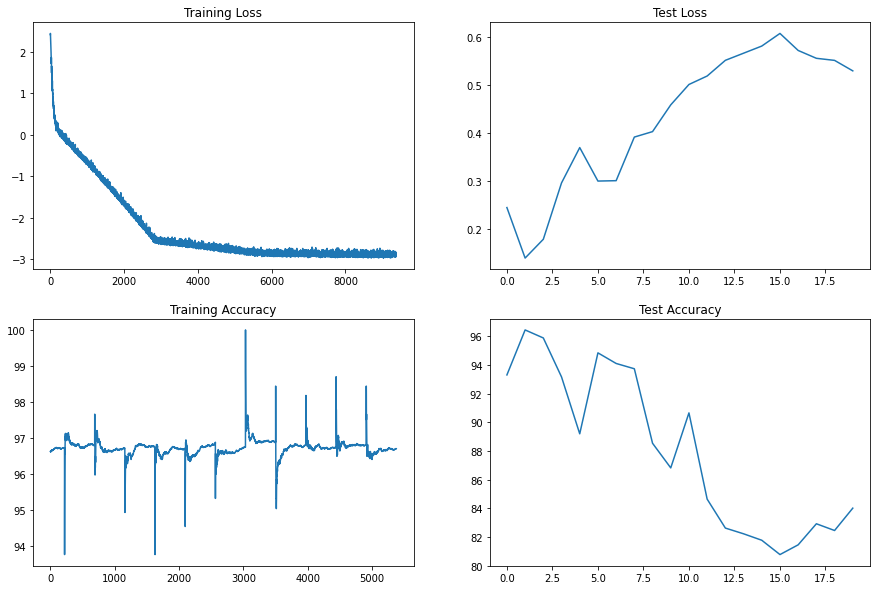

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [27]:
train_accuracy_logs['bn'] = train_acc
test_accuracy_logs['bn'] = test_acc
train_loss_logs['bn'] = train_losses
test_loss_logs['bn'] = test_losses

In [28]:
def plot_misclassification(model,test_loader):
  model.eval()
  misclassified_images = []    
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          _, pred = torch.max(output, 1)
          for i in range(len(pred)):
              if pred[i] != target[i]:
                  
                  misclassified_images.append({'image': data[i], 'predicted_class': pred[i], 'correct_class': target[i]})

 # Plot the misclassified images
  fig = plt.figure(figsize=(15, 5))
  for i in range(10):
      sub = fig.add_subplot(2, 5, i+1)
      misclassified_image = misclassified_images[i]
      plt.imshow(misclassified_image['image'].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
      sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
  plt.tight_layout()
  plt.show()

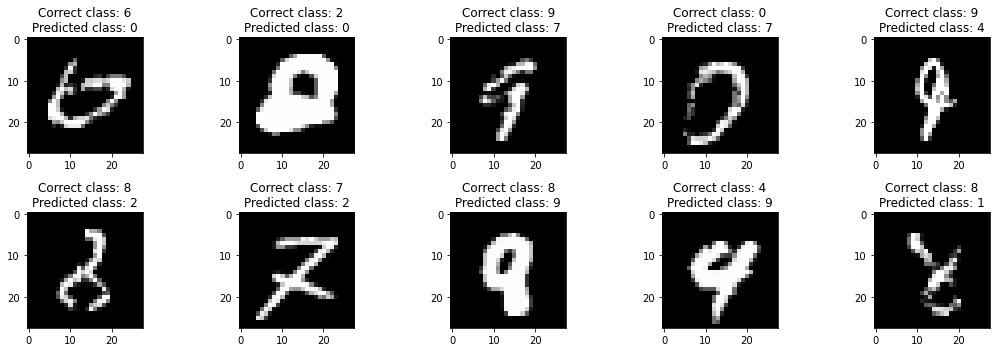

In [29]:
plot_misclassification(gn_model, test_loader)

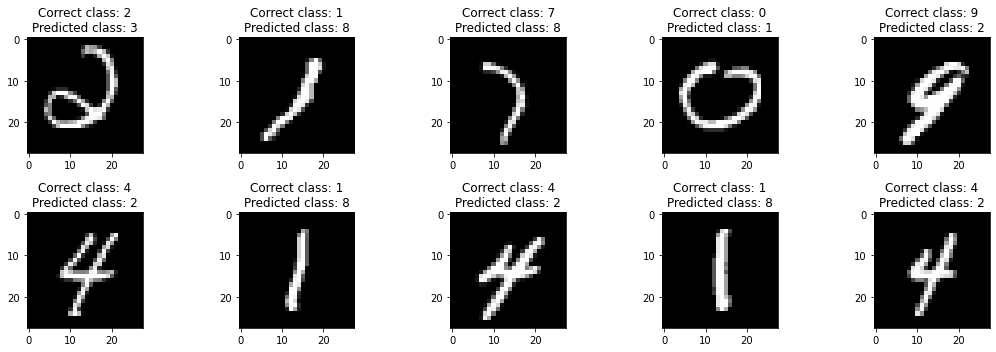

In [30]:
plot_misclassification(bn_model, test_loader)

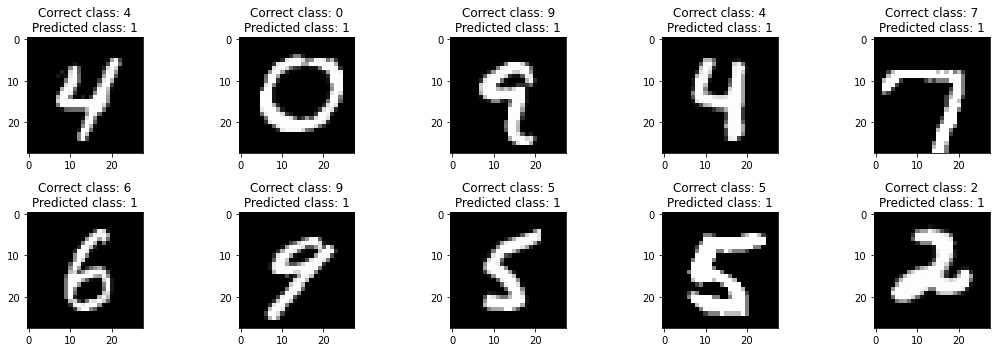

In [31]:
plot_misclassification(ln_model, test_loader)